# Lab 5

## Pre class checklist
Have you...

* Watched the video on Matplotlib (https://www.youtube.com/watch?v=qErBw-R2Ybk)? Not necessary but useful!
* Downloaded the dataset (check out the labs page and it will be linked there)?
* Downloaded VSCode?

From this lab on you dont need to create new branches, you can straight up save in your main branch on github. The submission will take place via canvas, you will have to upload your `.ipynb` notebook directly to canvas.

**How you will be graded**

This activity is out of 10 points. You will be graded on three things: completion, clear documentation, and correctness of your process.

* *Completion (4pts)*: This is solely whether you attempted and completed all portions of the computational assignment.
* *Documentation (4pts)*: Write comments above your code, describing what it does to demonstrate that you understand what the code is doing.
* *Correctness (2pts)*: Does your code run and produce the correct output?


# Playground!

In this section you will be given a set of tasks to complete on your own, and you will have to figure out how to do them using the resources provided (videos, documentation, etc). This way you can learn at your own pace and also get used to looking up documentation and learning how to use new tools on your own.

Note: We will have periodic check-ins through the class, just to make sure everyone atleast finishes a part of the activity before moving on!

The very first task is to import the required packages, this lab we will import a few datasets, create networks out of them, plot some statistics and finally fit a regression thorugh the plots.

Try importing the required libraries below (dont forget you can use the `as` keyword to give them a shorter alias):

In [14]:
import networkx as nx
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Loading data

#### 1.1 Loading a single dataset

For this lab we will work with `interactome datasets`. The interactome network of protein-protein interactions captures the structure of molecular machinery and gives rise to a bewildering degree of life complexity. A critical property of interactomes is the resilience to protein failures as the breakdown of proteins affects the exchange of any biological information between proteins in a cell and may lead to cell death or disease.

By studying interactomes from 1,840 species across the tree of life, we find that evolution leads to more resilient interactomes, providing evidence for a longstanding hypothesis that interactomes evolve favoring robustness against protein failures. We find that a highly resilient interactome has a beneficial impact on the organism's survival in complex, variable, and competitive habitats.

Answers to the question of PPI network evolution have implications for informing biology and answering numerous questions at the forefront of medicine, from interpreting genome-wide association data to drug target identification and drug discovery.

These interactions are stored as a directed edge list (with the first column indicating the source and the second indicating the target) within a few `.txt` files, with each file corresponding to a specific organism.

We can read a `.txt` file using `pl.read_csv()` as well, we will just have to define the separator (what is seperating two values) and the column names (since the `.txt` dont have them already):
```python
df = pl.read_csv("data_to_read.txt", separator = " ", has_header=False, new_columns=["source", "target"])
# Each column is seperated by a space hence the seperator is just a space.
# We want to tell python that this file doesnt already have headers (The column names) within the data, so we use the has_headers argument.
# new_columns defines the new column headers we want the DataFrame to have.
```

In the code cell below try loading one `.txt` in a variable named `df`.

In [15]:
df = pl.read_csv('../data/tol-species-data/3218.txt', separator = ' ', has_header = False, new_columns = ['source', 'target'])
df

source,target
str,str
"""PP1S100_107V6.1""","""PP1S3_324V6.1"""
"""PP1S100_107V6.1""","""PP1S196_120V6.1"""
"""PP1S100_107V6.1""","""PP1S66_138V6.1"""
"""PP1S100_107V6.1""","""PP1S167_155V6.1"""
"""PP1S100_107V6.1""","""PP1S98_5V6.1"""
…,…
"""PP1S9_92V6.1""","""PP1S2_113V6.1"""
"""PP1S9_92V6.1""","""PP1S455_2V6.1"""
"""PP1S9_92V6.1""","""PP1S10_194V6.1"""


#### 1.2 Creating a dictionary of datasets

This time we are going to work with a few different interactome networks, so we need to load all these datasets into Python.  

One way would be to create `df1`, `df2`, `df3`, and so on as separate variables. But as your code grows, this quickly becomes messy.  

Instead, we can use a **dictionary**. If you dont remember them from previous labs then think of a dictionary like a labeled storage box:  
- Each **key** is the label (like `"human"` or `"yeast"`)  
- Each **value** is what’s inside (in our case, a DataFrame).  

Example:
```python
sample_dict = {"key1": 1, "key2": 210}  # key:value pairs

# Adding a new entry:
sample_dict["key3"] = 234
print(sample_dict)
```
If we were to do the same with dataframes, it would look a bit like this,

```python
df_dict = {}
files_to_read = ["filepath1", "filepath2", "filepath3"]
for i in range(len(files_to_read)):
    df_tmp = pl.read_csv(files_to_read[i], seperator = " ", has_header=False, 
        new_columns=["source", "target"])

    df_dict[files_to_read[i]] = df_tmp
```

There might be other ways too! Above code is just one example. You can try writing your own code or use my example (make sure to comment all the code!).

Print out the dictionary after you create it.

In [16]:
df_dict = {}
files_to_read = ['3218', '4555', '4577', '7739', '9103', '9103', '13735', '28377', '88036', '316407']
for i in range(len(files_to_read)):
    file_path = f'../data/tol-species-data/{files_to_read[i]}.txt'
    df_temp = pl.read_csv(file_path, separator = ' ', has_header = False, new_columns = ['source', 'target'])

    df_dict[files_to_read[i]] = df_temp

## 2. Creating graphs from our data!

#### 2.1 Creating a single graph

From previous labs we know how to convert a single dataframe to a networkx graph. Till now we did it manually like this,
```python
G = nx.Graph() # We create an empty graph

# We add nodes
G.add_nodes_from(df['source'])
G.add_nodes_from(df['target'])

# Then we add edges
G.add_edges_from(df['source', 'target'].iter_rows())

```
This step-by-step approach shows what’s happening under the hood.

But in practice, networkx gives us a shortcut, it allows us to directly convert a dataframe to a graph using the `nx.from_pandas_edgelist()` function (although the functions asks for a pandas dataframe, it will also accept a polars dataframe). 

Example usage:
```python
G = nx.from_pandas_edgelist(df, source = <source_node>, target = <target_node>)
# Here we first input the dataframe we want to use, the source argument specifies which column is being used for source node and target argument specifies the column name for target node.
nx.draw(G, node_size = 10, node_color = "gray", alpha = 0.1)
```

Try using this function to create and draw a graph from one of your dataframes (try extracting the dataframe from you dictionary of dataframes).

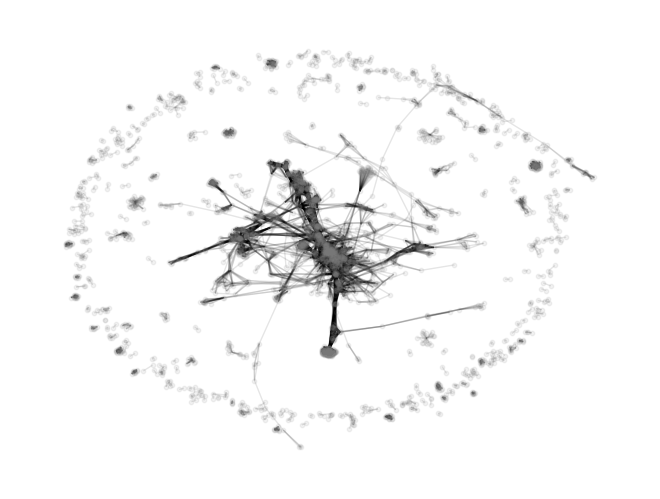

In [17]:
G = nx.from_pandas_edgelist(df_dict['4555'], source = 'source', target = 'target')
nx.draw(G, node_size = 10, node_color = 'gray', alpha = 0.1)

#### 2.2 Dictionary of Graphs

Just like we created a dictionary of dataframes, we can also create a dictionary of graph objects. 

Try creating a dictionary of Graphs for all your dataframes.

Hint: Refactor the code you used to create the dataframe dictionary.

In [18]:
# Empty dict like before but for graphs.
G_dict = {}

# Loop through each key-value pair in `df_dict`.
for filename, df in df_dict.items():

    # For each df, make a graph using the networkx function.
    G_temp = nx.from_pandas_edgelist(df, source='source', target='target')
    
    # Add newly created graph to `G_dict`.
    G_dict[filename] = G_temp

Now we can use this dictionary to draw your graphs using `nx.draw()`, you can try and play around with your visualization like making node size proportional to its degree! Below is the code to do that.

```python
fig, ax = plt.subplots(figsize = (12,12), nrows = 3, ncols = 3)

for idx, i in enumerate(files_to_read):
    G_tmp = G_dict[i]
    n_dict = dict(G_tmp.degree)
    nx.draw(G_tmp, nodelist=n_dict.keys(), node_size=[v * 10 for v in n_dict.values()], node_color = "gray", alpha = 0.1, ax=ax[int(idx // 3), int(idx % 3)])
    ax[int(idx // 3), int(idx % 3)].set_title(i)

plt.tight_layout()
```

Try to figure out what each line is doing in this code and add those comments! You can also try to play around with the arguments on your own, maybe change the node size based on each node's clustering coefficient?

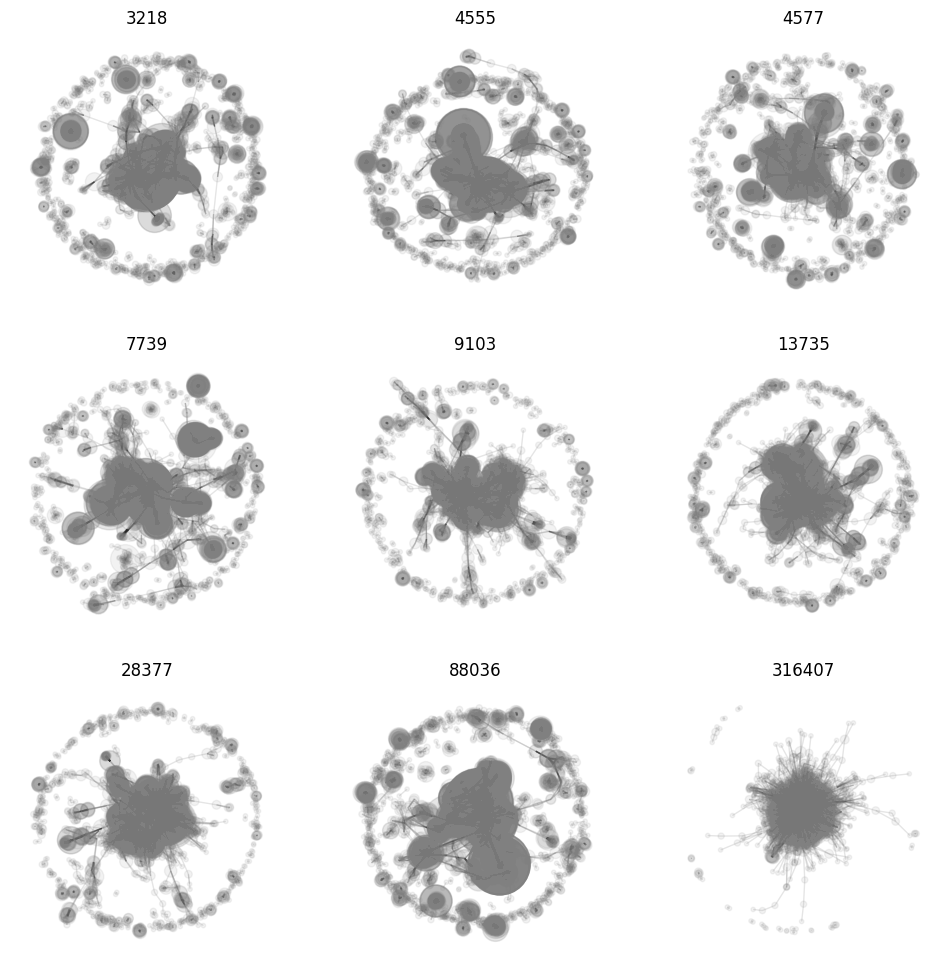

In [19]:
fig, ax = plt.subplots(figsize = (12,12), nrows = 3, ncols = 3)

for idx, i in enumerate(G_dict.keys()):
    G_temp = G_dict[i]
    n_dict = dict(G_temp.degree)
    nx.draw(G_temp, nodelist = n_dict.keys(), node_size = [v * 10 for v in n_dict.values()], node_color = "gray", alpha = 0.1, ax = ax[int(idx // 3), int(idx % 3)]) # Drawing after splitting axes.
    ax[int(idx // 3), int(idx % 3)].set_title(i) # Labeling grid positions.

## 3. Plotting network statistics

#### 3.1 Frequency vs Degree plot

Lets start with a simple frequency plot for our network degrees. We can already create a list with degrees of each node from our Graph. We just have to find a way to plot this list as a graph. For this we can use the `matplotlib` library.

To plot a simple frequency plot from a list, we can do the following,

```python
lst = [3,3,3,3,1,1,1,2,2,2,2,2,4,5,5,5,5]
vals, freq = np.unique(lst, return_counts = True)
# np.unique looks for each unique element and returns two arrays, one with the unique elements and second with their frequency.

print(f"Unique values: {vals}")
print(f"Frequencies: {freq}")

plt.scatter(vals, freq, marker = 'o')
# plt.scatter just puts a point on a graph corresponding to each value of vals as x-axis and freq as y-axis.
plt.show()
```

We can adapt this code to print our degree distribution!
```python
degrees = [deg for _, deg in G.degree()] # For any graph G

vals, freq = np.unique(degrees, return_counts=True)

plt.scatter(vals, freq, marker="o")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree distribution (yeast)")
plt.show()
```

Try it out on your own, use a `for` loop to iterate over your graph dictionary and print the degree distributions for each!


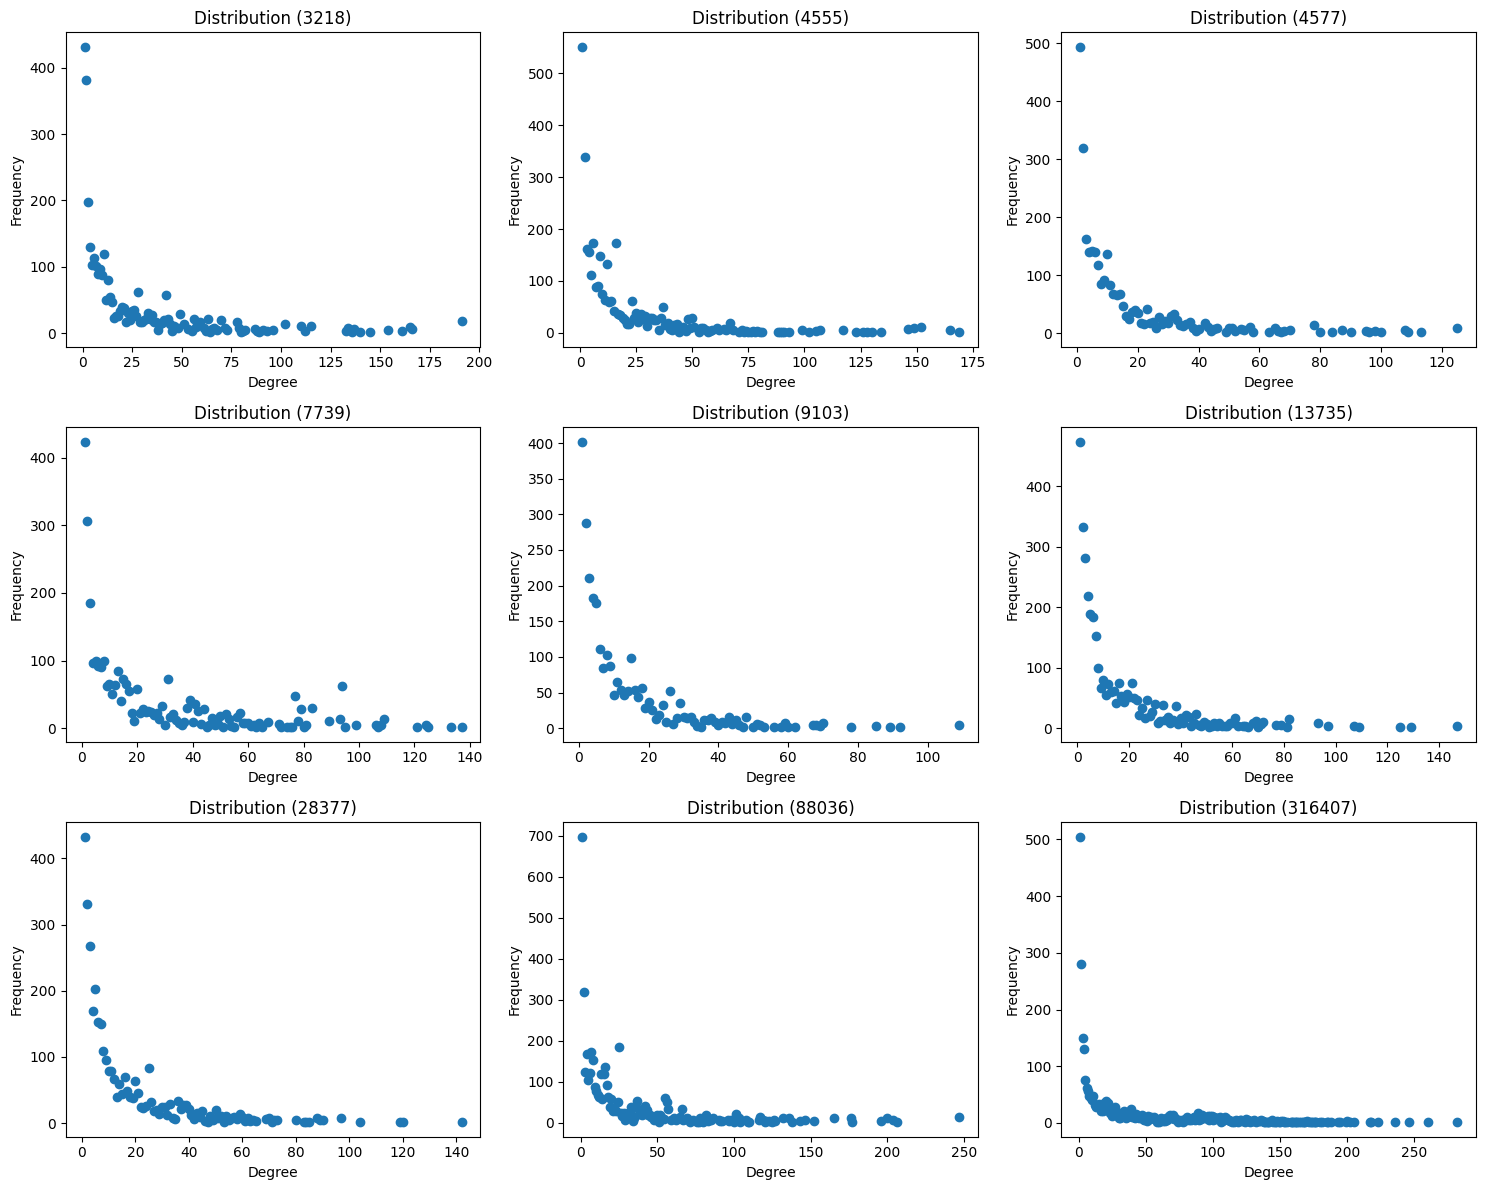

In [20]:
fig, ax = plt.subplots(figsize = (15, 12), nrows = 3, ncols = 3)

# Going through `G_dict`.
for idx, (filename, G) in enumerate(G_dict.items()):

    # Abhay's formatting.
    degrees = [deg for _, deg in G.degree()]
    vals, freq = np.unique(degrees, return_counts = True)
    
    # Tweak on Abhay's formatting to get the grid effect.
    row = idx // 3
    col = idx % 3
    
    # Instead of plt.scatter, we use ax[row, col].scatter for the grid effect.
    ax[row, col].scatter(vals, freq, marker = 'o')
    
    # Use `.set_xlabel()`, `.set_ylabel()` and `.set_title()` for the specific subplot.
    ax[row, col].set_xlabel('Degree')
    ax[row, col].set_ylabel('Frequency')
    ax[row, col].set_title(f'Distribution ({filename})')

plt.tight_layout()
plt.show()

#### 3.2 Converting the graph to log scale

In many biological networks, the degree distribution is very skewed:
- Lots of nodes have very low degree
- A few nodes have very high degree  

On a **linear scale**, this makes the plot look squished to the left.  
A good trick is to switch to a **logarithmic scale** for the axes.

Matplotlib allows you to play around with the scaling of each axis in your graph. By default the scaling is linear, but you can use `plt.xscale('log')` and `plt.yscale('log')` to change the scaling into a logarithimic. 

Use the code from your previous code cell and just add these two commands before `plt.show()`, do you see any change?



Unfortunately, with the way that I've set it up this only affects the very last plot. To fix this I can add
```python
    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
```
I definitely do see how it has become more of a straighter line correlation.

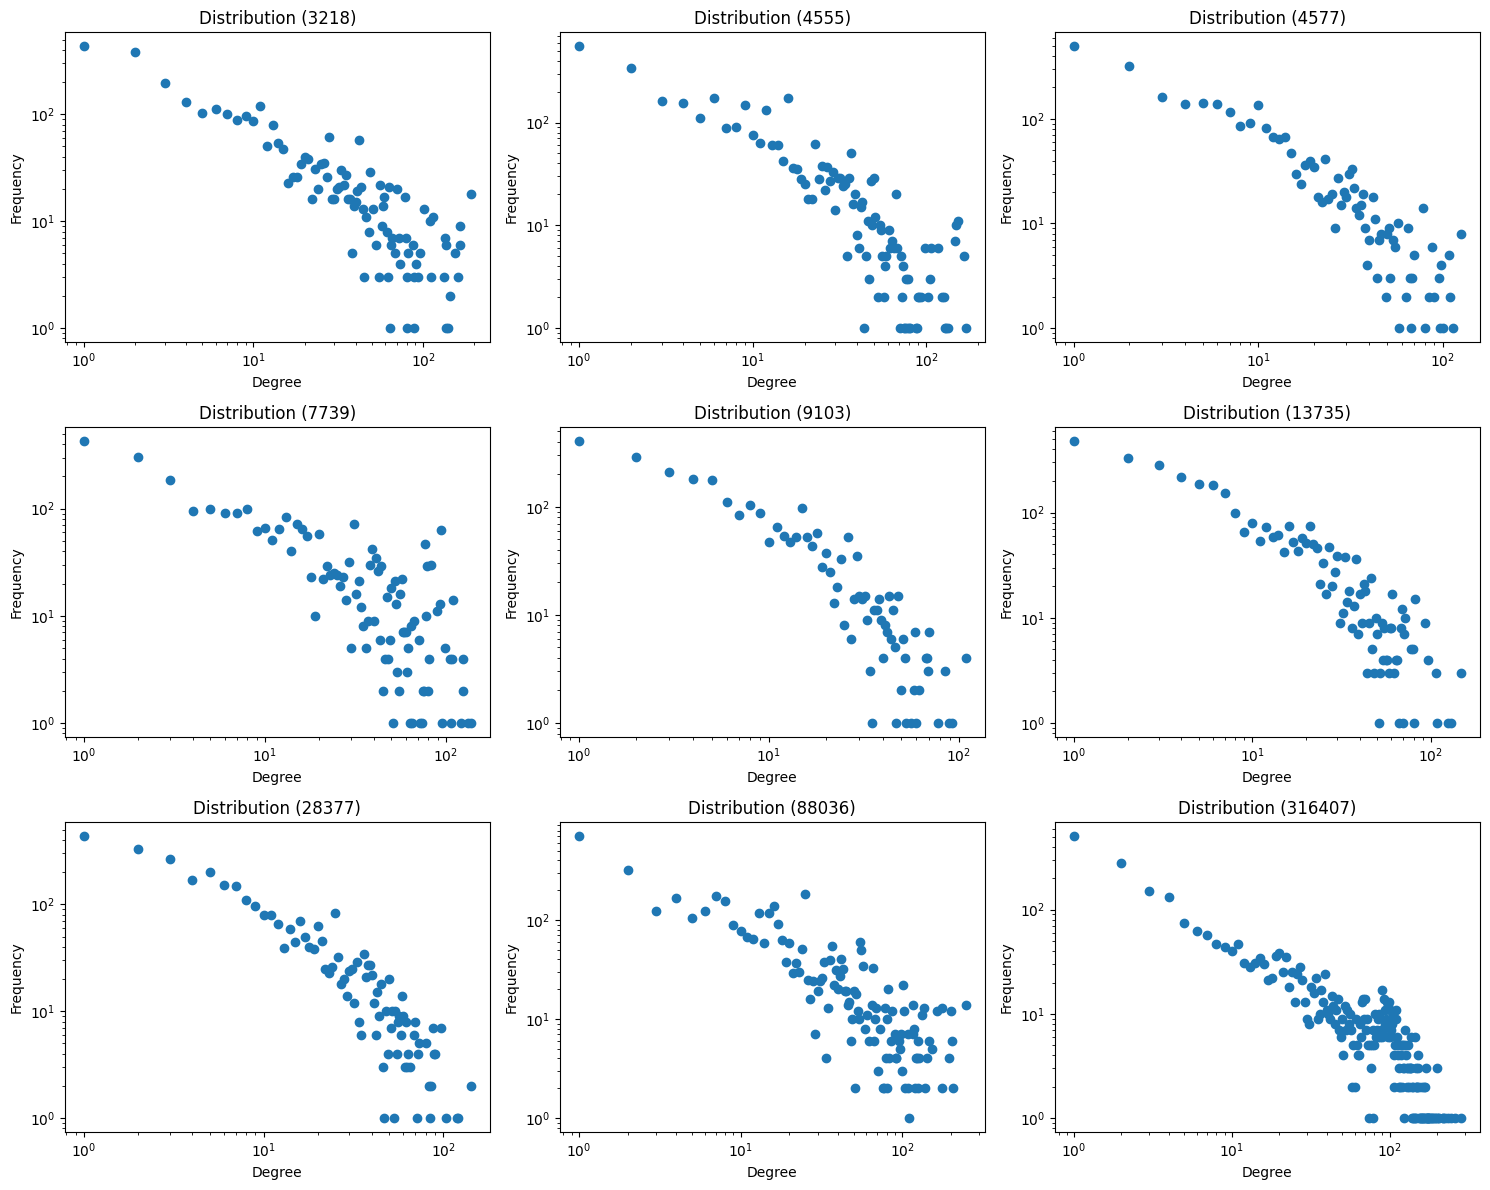

In [21]:

fig, ax = plt.subplots(figsize = (15, 12), nrows = 3, ncols = 3)

for idx, (filename, G) in enumerate(G_dict.items()):
    
    # Abhay's formatting.
    degrees = [deg for _, deg in G.degree()] 
    vals, freq = np.unique(degrees, return_counts = True)
    
    # Tweak on Abhay's formatting to get the grid effect.
    row = idx // 3
    col = idx % 3
    
    # Instead of plt.scatter, we use ax[row, col].scatter.
    ax[row, col].scatter(vals, freq, marker = "o")

    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    
    # Use `.set_xlabel()`, `.set_ylabel()` and `.set_title()` for the specific subplot.
    ax[row, col].set_xlabel("Degree")
    ax[row, col].set_ylabel("Frequency")
    ax[row, col].set_title(f"Distribution ({filename})")

plt.tight_layout()
plt.show()

#### 3.3 Regression

The final step is to fit a regression line to our degree distribution in **log-log space**.  

Why?  
If the data points roughly fall on a straight line, it suggests that the degree distribution follows a **power-law**, which is a hallmark of scale-free networks (common in biology!).


Your task:  
- Fit a regression line on the log-log degree distribution.  
- Overlay that line on your scatterplot.  

Hint: `np.polyfit()` might come in handy, use to on the LOG of x and y. This gives us the slope and intercept for $log(y) = m * log(x) + b$ which translates to $y = e^b x^m$, dont forget you can also consult the internet or call me over!

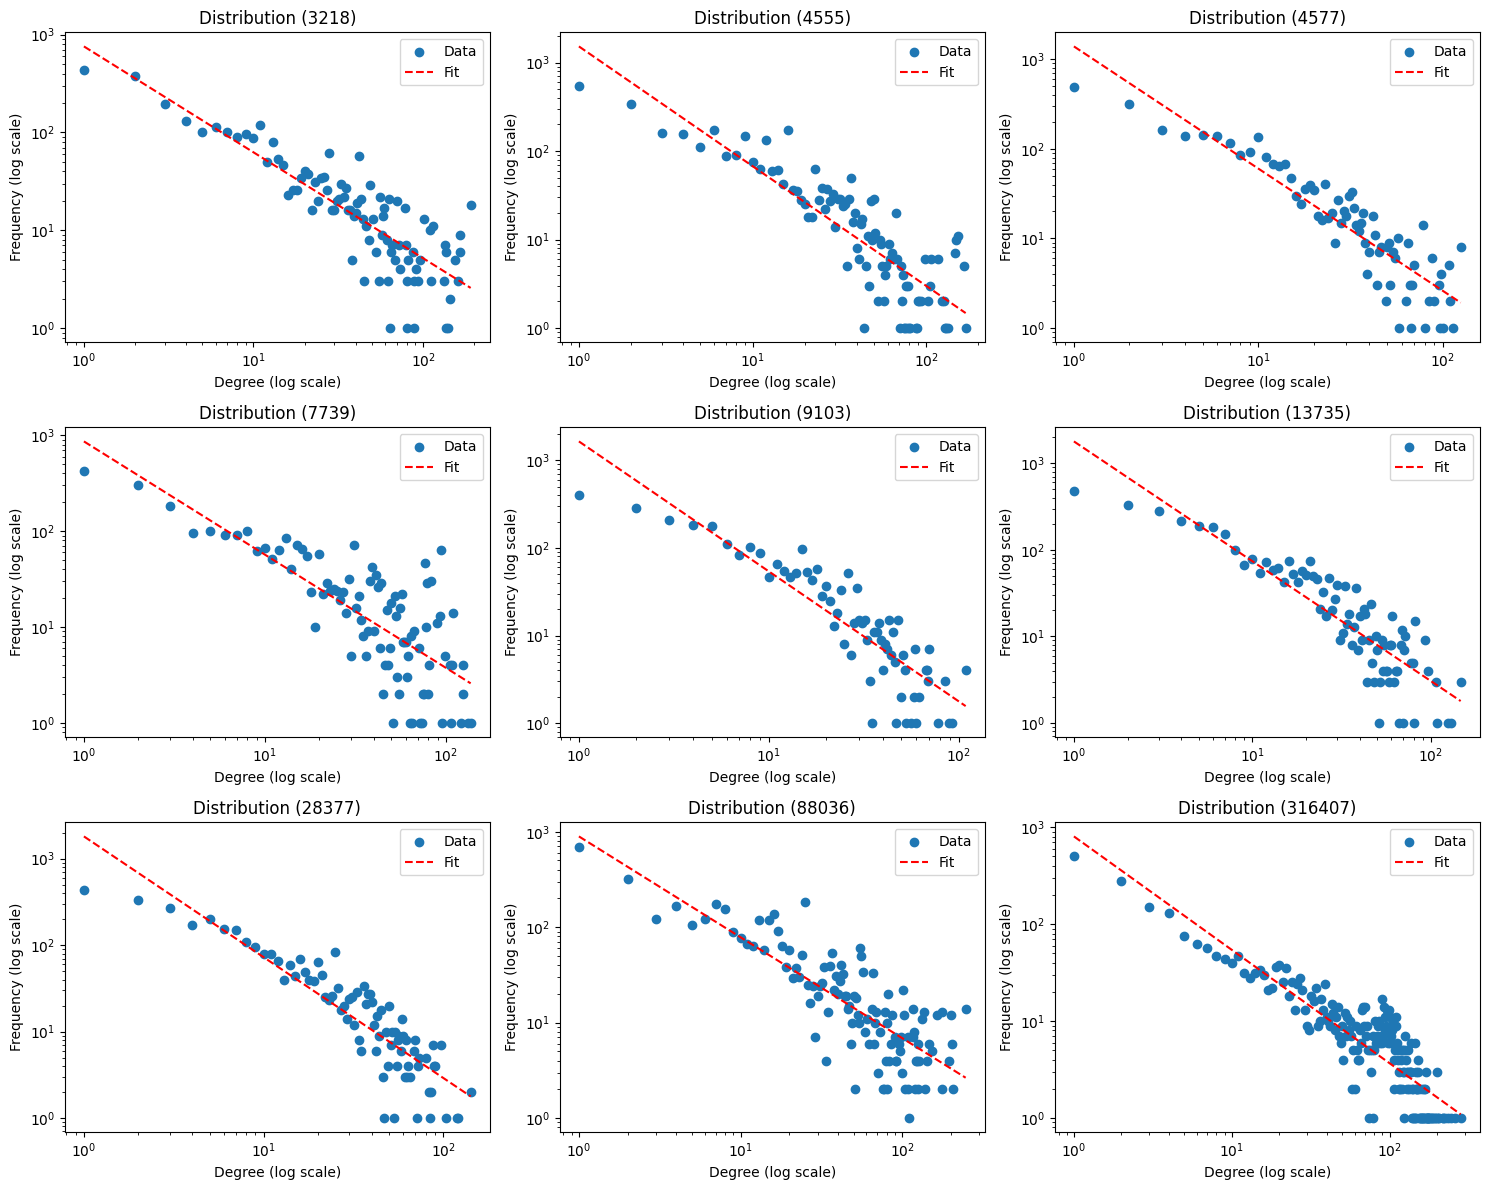

In [22]:

fig, ax = plt.subplots(figsize = (15, 12), nrows = 3, ncols = 3)

# Loop through each graph in the dictionary.
for idx, (filename, G) in enumerate(G_dict.items()):
    
    # Same degree calculation as before.
    degrees = [deg for _, deg in G.degree()]
    vals, freq = np.unique(degrees, return_counts = True)
    
    # Same subplot positioning.
    row = idx // 3
    col = idx % 3
    
    # Same plot but now with label.
    ax[row, col].scatter(vals, freq, marker="o", label='Data')

    # REGRESSION
    
    # We need to fit a line to the LOG of the data, degree 1 for linear fit.
    # This returns the slope (m) and intercept (b) of the line in log-space.
    m, b = np.polyfit(np.log10(vals), np.log10(freq), 1)
    
    # Calculate the y-values for the regression line using the power-law equation.
    # The equation for the line is y = (10^b) * (x^m) (Googled).
    y_fit = (10**b) * (vals**m)
    
    # Plot the regression line on the same subplot.
    ax[row, col].plot(vals, y_fit, color='red', linestyle='--', label='Fit')

    # REGRESSION DONE
        
    # Log scale, add details, plot.
    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    ax[row, col].set_xlabel("Degree (log scale)")
    ax[row, col].set_ylabel("Frequency (log scale)")
    ax[row, col].set_title(f"Distribution ({filename})")
    ax[row, col].legend() # Display the legend.

# Adjust layout and show the final plot
plt.tight_layout()
plt.show()

# Extra Credit!

Can you use plot all the graphs/networks within the same figure, as a grid?

Matplotlib allows you to do this, you will get **1 EXTRA POINT** if you successfully do this!

Rahul: I was just doing this unknowingly with great effort, thank god it's extra credit!

**After the completion of this lab**
1. List the people with whom you worked on this lab.
2. Go to Canvas, and submit your `lab5.ipynb` under the assignments tab (No need to deal with GitHub, Yay!).